<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Loading" data-toc-modified-id="Loading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading</a></span><ul class="toc-item"><li><span><a href="#Load-saved-histograms" data-toc-modified-id="Load-saved-histograms-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load saved histograms</a></span></li><li><span><a href="#Load-loc_dict" data-toc-modified-id="Load-loc_dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load <code>loc_dict</code></a></span></li><li><span><a href="#Get-urban-v.-rural-indices" data-toc-modified-id="Get-urban-v.-rural-indices-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get urban v. rural indices</a></span></li><li><span><a href="#Create-country_indices-and-country_labels" data-toc-modified-id="Create-country_indices-and-country_labels-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create <code>country_indices</code> and <code>country_labels</code></a></span></li><li><span><a href="#Get-folds" data-toc-modified-id="Get-folds-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Get folds</a></span></li></ul></li><li><span><a href="#General-Plotting-Code" data-toc-modified-id="General-Plotting-Code-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>General Plotting Code</a></span></li><li><span><a href="#Results-(preds-directly-from-Resnets)" data-toc-modified-id="Results-(preds-directly-from-Resnets)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results (preds directly from Resnets)</a></span><ul class="toc-item"><li><span><a href="#Get-test-preds" data-toc-modified-id="Get-test-preds-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Get test preds</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#Results-(ridge-CV-on-Resnet-features)" data-toc-modified-id="Results-(ridge-CV-on-Resnet-features)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results (ridge CV on Resnet features)</a></span><ul class="toc-item"><li><span><a href="#Get-test-preds" data-toc-modified-id="Get-test-preds-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Get test preds</a></span></li><li><span><a href="#Write-to-CSV" data-toc-modified-id="Write-to-CSV-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Write to CSV</a></span><ul class="toc-item"><li><span><a href="#Predictions" data-toc-modified-id="Predictions-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Predictions</a></span></li><li><span><a href="#Per-country-r^2" data-toc-modified-id="Per-country-r^2-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Per-country r^2</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Plot</a></span></li></ul></li></ul></div>

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../')
from batchers import dataset_constants
from utils.analysis import evaluate
from utils.general import load_npz

In [2]:
LOGS_ROOT_DIR = '../logs/'
DATASET_NAME = '2009-17'
KEEPS = [0.05, 0.1, 0.25, 0.5]
SPLITS = ['train', 'val', 'test']
SEEDS = [123, 456, 789]

# Loading

## Load saved histograms

In [3]:
file_path = '../data/dhs_image_hists.npz'
npz = load_npz(file_path)

image_hists = npz['image_hists']
labels = npz['labels']
locs = npz['locs']
years = npz['years']

num_examples = len(image_hists)
assert np.all(np.asarray([len(labels), len(locs), len(years)]) == num_examples)

image_hists: dtype=int64, shape=(19669, 8, 102)
labels: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
years: dtype=int32, shape=(19669,)
nls_center: dtype=float32, shape=(19669,)
nls_mean: dtype=float32, shape=(19669,)


## Load `loc_dict`

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': 0,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    },
    ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [4]:
loc_dict_path = '../data/dhs_loc_dict.pkl'
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

## Get urban v. rural indices

In [5]:
def get_urban_rural_indices(locs):
    '''
    Args
    - locs: np.array, shape [N, 2]

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 0:
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print('num urban: {}\t num rural: {}'.format(len(urban_indices), len(rural_indices)))
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs)

num urban: 6801	 num rural: 12868


## Create `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```
{
    ...
    'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]),
    ...
}
```

`country_labels` is a `np.array` that shows which country each example belongs to
```
    np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.COUNTRIES`

In [6]:
country_indices = defaultdict(list)

for i, (lat, lon) in enumerate(locs):
    country = loc_dict[(lat, lon)]['country']
    country_indices[country].append(i)

for country in country_indices:
    country_indices[country] = np.asarray(country_indices[country])

In [7]:
country_labels = np.zeros(num_examples, dtype=np.int32)

for i, country in enumerate(dataset_constants.DHS_COUNTRIES):
    indices = country_indices[country]
    country_labels[indices] = i

In [8]:
country_year_indices = defaultdict(list)

for i, (lat, lon) in enumerate(locs):
    cy = loc_dict[(lat, lon)]['country_year']
    country_year_indices[cy].append(i)

for cy in country_year_indices:
    country_year_indices[cy] = np.asarray(country_year_indices[cy])

In [9]:
def get_indices_for_countries(countries):
    indices = np.sort(np.concatenate([
        country_indices[country] for country in countries
    ]))
    return indices

## Get folds

`folds`: maps fold into a dict, which maps split into a list of country names for that fold.

```
folds['A'] = {
    'train': ['country1', 'country2', ...],
    'val': ...
    'test': ...
}
```

`fold_test_indices`: maps fold into indices corresponding to test countries in that fold
```
fold_test_indices['A'] = np.array
```

In [10]:
FOLDS = ['A', 'B', 'C', 'D', 'E']

folds = {
    'A': dataset_constants.SURVEY_NAMES['2009-17A'],
    'B': dataset_constants.SURVEY_NAMES['2009-17B'],
    'C': dataset_constants.SURVEY_NAMES['2009-17C'],
    'D': dataset_constants.SURVEY_NAMES['2009-17D'],
    'E': dataset_constants.SURVEY_NAMES['2009-17E'],
}

In [11]:
fold_test_indices = {
    f: get_indices_for_countries(folds[f]['test'])
    for f in folds
}
fold_test_indices['all'] = np.arange(num_examples)

# General Plotting Code

In [12]:
def plot_shaded(ax, data, label, color, ylims=None):
    '''Plots a line with +/- 2 std dev shaded region.

    Args
    - ax: matplotlib.axes.Axes
    - data: dict, maps x-coordinates to list of values
    - label: str, for legend
    - color: str
    - ylims: tuple, (bottom, top)
    '''
    means = []
    stds = []
    xs = []
    x_points = []
    y_points = []

    for x, values in data.items():
        xs.append(x)
        means.append(np.mean(values))
        stds.append(np.std(values))

        for value in values:
            x_points.append(x)
            y_points.append(value)

    means = np.asarray(means)
    stds = np.asarray(stds)

    # ax.scatter(x_points, y_points, alpha=0.8, color=color)  # alpha=0 is transparent
    ax.plot(xs, means, label=label, color=color)
    ax.fill_between(xs, means - 2 * stds, means + 2 * stds, facecolor=color, alpha=0.2)
    if ylims is not None:
        ax.set_ylim(bottom=ylims[0], top=ylims[1])

In [13]:
COLORS = {
    'nl': 'black',
    'ms': 'green',
    'msnl': 'blue',
    'msnl_concat': 'cyan',
    'ms_transfer': 'lightblue',
    'rgb': 'red',
    'rgbnl': 'orange',
    'rgbnl_concat': 'magenta',
    'rgb_transfer': 'rosybrown',
    'nls_mean_knn': 'purple'
}

In [14]:
def plot_metric_v_keep(ax, metrics, ylabel, title=None, ylims=None, legend=True):
    '''
    Args
    - ax: matplotlib.axes.Axes
    - split: str, one of ['train', 'val', 'test']
    - metrics: dict, metrics[model_name][keep_frac] => list of values
    - ylabel: str, either 'r^2' or 'R^2'
    - ylims: tuple, (bottom, top)
    - legend: bool
    '''
    for model_name in metrics:
        data = metrics[model_name]
        plot_shaded(ax, data=data, label=model_name, color=COLORS[model_name], ylims=ylims)
    if title is None:
        ax.set_title('Performance vs. Fraction of Training Data Used')
    else:
        ax.set_title(title)
    ax.set_xlabel('Fraction of training data used')
    ax.set_ylabel(ylabel)
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True)

# Results (preds directly from Resnets)

TODO: These results have not been run yet.

## Get test preds

In [ ]:
BANDS = ['ms', 'msnl', 'nl', 'rgb', 'rgbnl']

def get_test_preds(bands, keep_frac, seed):
    dirname = f'resnet_{bands}_keep{keep_frac}'
    dir_path = os.path.join(LOGS_ROOT_DIR, 'dhs_resnet', dirname)
    test_preds = np.zeros(num_examples)
    for f in folds:
        npz_filename = f'test_preds_2009-17{f}_seed{seed}.npz'
        npz_path = os.path.join(dir_path, npz_filename)
        test_indices = fold_test_indices[f]
        test_preds[test_indices] = load_npz(
            npz_path,
            check=dict(locs=locs[test_indices], labels=labels[test_indices]))['preds']
    return test_preds

preds = {}

for bands in BANDS:
    for keep_frac in KEEPS:
        for seed in SEEDS:
            preds[(bands, keep_frac, seed)] = get_test_preds(bands, keep_frac, seed)

for bands in BANDS:
    npz_path = os.path.join(LOGS_ROOT_DIR, 'dhs_resnet', 'resnet_' + bands, 'test_preds.npz')
    preds[(bands, 1.0)] = load_npz(npz_path)['test_preds']

In [ ]:
test_df_data = []

for bands in BANDS:
    for keep_frac in KEEPS:
        for seed in SEEDS:
            for f in folds:
                indices = fold_test_indices[f]
                r2, R2, mse, _ = evaluate(
                    labels=labels[indices],
                    preds=preds[(bands, keep_frac, seed)][indices])
                row = [bands, keep_frac, seed, f, r2, R2, mse]
                test_df_data.append(row)
            r2, R2, mse, _ = evaluate(
                labels=labels,
                preds=preds[(bands, keep_frac, seed)])
            row = [bands, keep_frac, seed, 'all', r2, R2, mse]
            test_df_data.append(row)

test_df = pd.DataFrame.from_records(
    test_df_data,
    columns=['bands', 'keep_frac', 'seed', 'fold', 'r2', 'R2', 'mse'],
    index=['bands', 'keep_frac', 'seed', 'fold']
)
test_df = test_df.unstack('seed')
display(test_df.style.format('{:.4f}'))

In [ ]:
r2s = {}  # r2s[fold][bands][keep_frac] = list of values
R2s = {}
mses = {}

for f in FOLDS + ['all']:
    for d, name in [(r2s, 'r2'), (R2s, 'R2'), (mses, 'mse')]:
        d[f] = {
            bands: {
                keep_frac: test_df.loc[(bands, keep_frac, f), name].tolist()
                for keep_frac in KEEPS
            }
            for bands in BANDS
        }

for bands in BANDS:
    for f in FOLDS + ['all']:
        indices = fold_test_indices[f]
        r2, R2, mse, _ = evaluate(
            labels=labels[indices],
            preds=preds[(bands, 1.0)][indices])
        r2s[f][bands][1.0] = [r2]
        R2s[f][bands][1.0] = [R2]
        mses[f][bands][1.0] = [mse]

## Plot

In [ ]:
for (metrics, ylabel, ylims) in [
    (r2s, 'r^2', (0.2, 0.8)),
    (R2s, 'R^2', (0.2, 0.8)),
    (mses, 'mse', (0.1, 0.7))
]:
    fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[20, 4])
    for i, f in enumerate(FOLDS):
        title = 'Fold: ' + f
        plot_metric_v_keep(ax=axs[i], metrics=metrics[f], ylabel=ylabel,
                           title=title, ylims=ylims, legend=(i==4))
    fig.tight_layout()

    fig, ax = plt.subplots(1, 1, figsize=[8, 5])
    plot_metric_v_keep(ax=ax, metrics=metrics['all'], ylabel=ylabel,
                       title='Fold: all', ylims=ylims)
    fig.tight_layout()
    plt.show()

# Results (ridge CV on Resnet features)

## Get test preds

In [15]:
# BANDS = ['ms', 'msnl', 'nl', 'rgb', 'rgbnl',
#          'msnl_concat', 'rgbnl_concat',
#          'ms_transfer', 'rgb_transfer', 'nls_mean_knn']
BANDS = ['ms', 'msnl_concat', 'nl', 'ms_transfer', 'rgb_transfer']

transfer_dirs = {
    'rgb_transfer': 'transfer_2009-17nl_nlcenter_18preact_rgb_b64_fc001_conv001_lr0001',
    'ms_transfer': 'transfer_2009-17nl_nlcenter_18preact_ms_b64_fc001_conv001_lr0001',
}

def get_test_preds(bands, keep_frac, seed):
    if 'transfer' in bands:
        dirname = transfer_dirs[bands]
        npz_filename = f'test_preds_keep{keep_frac}_seed{seed}.npz'
        npz_path = os.path.join(LOGS_ROOT_DIR, dirname, npz_filename)
    elif 'knn' in bands:
        dirname = bands.replace('_knn', '')
        npz_filename = f'test_preds_keep{keep_frac}_seed{seed}.npz'
        npz_path = os.path.join(LOGS_ROOT_DIR, 'dhs_knn', dirname, npz_filename)
    else:
        npz_filename = f'test_preds_keep{keep_frac}_seed{seed}.npz'
        npz_path = os.path.join(LOGS_ROOT_DIR, 'dhs_resnet', bands, npz_filename)
    test_preds = load_npz(npz_path)['test_preds']
    return test_preds

preds = {}

for bands in BANDS:
    for keep_frac in KEEPS:
        for seed in SEEDS:
            preds[(bands, keep_frac, seed)] = get_test_preds(bands, keep_frac, seed)

for bands in BANDS:
    if 'transfer' in bands:
        dirname = transfer_dirs[bands]
        npz_path = os.path.join(LOGS_ROOT_DIR, dirname, 'test_preds.npz')
    elif 'knn' in bands:
        dirname = bands.replace('_knn', '')
        npz_path = os.path.join(LOGS_ROOT_DIR, 'dhs_knn', dirname, 'test_preds.npz')
    else:
        dirname = bands
        npz_path = os.path.join(LOGS_ROOT_DIR, 'dhs_resnet', dirname, 'test_preds.npz')

    preds[(bands, 1.0)] = load_npz(npz_path)['test_preds']

test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
test_preds: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
test_preds: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
test_preds: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
test_preds: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
test_preds: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
test_preds: dtyp

In [16]:
test_df_data = []

for bands in BANDS:
    for keep_frac in KEEPS:
        for seed in SEEDS:
            for f in folds:
                indices = fold_test_indices[f]
                r2, R2, mse, _ = evaluate(
                    labels=labels[indices],
                    preds=preds[(bands, keep_frac, seed)][indices])
                row = [bands, keep_frac, seed, f, r2, R2, mse]
                test_df_data.append(row)
            r2, R2, mse, _ = evaluate(
                labels=labels,
                preds=preds[(bands, keep_frac, seed)])
            row = [bands, keep_frac, seed, 'all', r2, R2, mse]
            test_df_data.append(row)

test_df = pd.DataFrame.from_records(
    test_df_data,
    columns=['bands', 'keep_frac', 'seed', 'fold', 'r2', 'R2', 'mse'],
    index=['bands', 'keep_frac', 'seed', 'fold'])
test_df = test_df.unstack('seed')
display(test_df.style.format('{:.4f}'))

In [17]:
r2s = {}  # r2s[fold][bands][keep_frac] = list of values
R2s = {}
mses = {}

for fold in FOLDS + ['all']:
    for d, name in [(r2s, 'r2'), (R2s, 'R2'), (mses, 'mse')]:
        d[fold] = {
            bands: {
                keep_frac: test_df.loc[(bands, keep_frac, fold), name].tolist()
                for keep_frac in KEEPS
            }
            for bands in BANDS
        }

for bands in BANDS:
    for f in FOLDS + ['all']:
        indices = fold_test_indices[f]
        r2, R2, mse, _ = evaluate(
            labels=labels[indices],
            preds=preds[(bands, 1.0)][indices])
        r2s[f][bands][1.0] = [r2]
        R2s[f][bands][1.0] = [R2]
        mses[f][bands][1.0] = [mse]

## Write to CSV

### Predictions

In [18]:
MODEL_CONVERSION = {
    'nl': 'Resnet-18 NL',
    'ms': 'Resnet-18 MS',
    'msnl': 'Resnet-18 MS+NL',
    'msnl_concat': 'Resnet-18 MS+NL concat',
    'ms_transfer': 'Resnet-18 MS Transfer',
    'rgb': 'Resnet-18 RGB',
    'rgbnl': 'Resnet-18 RGB+NL',
    'rgbnl_concat': 'Resnet-18 RGB+NL concat',
    'rgb_transfer': 'Resnet-18 RGB Transfer',
}

model_names = []
for bands in BANDS:
    m = MODEL_CONVERSION[bands]
    for k in KEEPS + [1.0]:
        for s in SEEDS:
            if k == 1.0:
                model_name = '{m}, keep{k}'.format(m=m, k=k)
            else:
                model_name = '{m}, keep{k}, seed{s}'.format(m=m, k=k, s=s)
            model_names.append(model_name)

preds_df = pd.DataFrame(
    columns=['lat', 'lon', 'country', 'country_year', 'urban', 'wealthpooled'] + model_names)
preds_df['lat'] = locs[:, 0]
preds_df['lon'] = locs[:, 1]

for country in country_indices:
    preds_df.loc[country_indices[country], 'country'] = country

for country_year in country_year_indices:
    preds_df.loc[country_year_indices[country_year], 'country_year'] = country_year

preds_df.loc[:, 'urban'] = False
preds_df.loc[urban_indices, 'urban'] = True

preds_df['wealthpooled'] = labels

model_names = []
for bands in BANDS:
    m = MODEL_CONVERSION[bands]
    for k in KEEPS + [1.0]:
        for s in SEEDS:
            if k == 1.0:
                model_name = '{m}, keep{k}'.format(m=m, k=k)
                preds_df[model_name] = preds[(bands, k)]
            else:
                model_name = '{m}, keep{k}, seed{s}'.format(m=m, k=k, s=s)
                preds_df[model_name] = preds[(bands, k, s)]

preds_df.to_csv('preds_keep.csv', index=False)

### Per-country r^2

In [19]:
test_df_data = []

for bands in BANDS:
    model_name = MODEL_CONVERSION[bands]
    for keep_frac in KEEPS + [1.0]:
        if keep_frac == 1.0:
            possible_seeds = [123]
        else:
            possible_seeds = SEEDS
        for seed in possible_seeds:
            if keep_frac == 1.0:
                model_selector = (bands, 1.0)
            else:
                model_selector = (bands, keep_frac, seed)

            for country in dataset_constants.DHS_COUNTRIES:
                indices = country_indices[country]
                r2, R2, mse, _ = evaluate(
                    preds=preds[model_selector][indices],
                    labels=labels[indices]
                )
                row = [model_name, keep_frac, seed, country, r2, R2, mse]
                test_df_data.append(row)
            r2, R2, mse, _ = evaluate(
                preds=preds[model_selector],
                labels=labels
            )
            row = [model_name, keep_frac, seed, 'overall', r2, R2, mse]
            test_df_data.append(row)

test_df = pd.DataFrame.from_records(
    test_df_data,
    columns=['model', 'keep_frac', 'seed', 'country', 'r2', 'R2', 'mse'],
    index=['model', 'keep_frac', 'seed', 'country']
)
display(test_df.style.format('{:.4f}'))

test_df.to_csv('r2_keep.csv', index=True)

## Plot

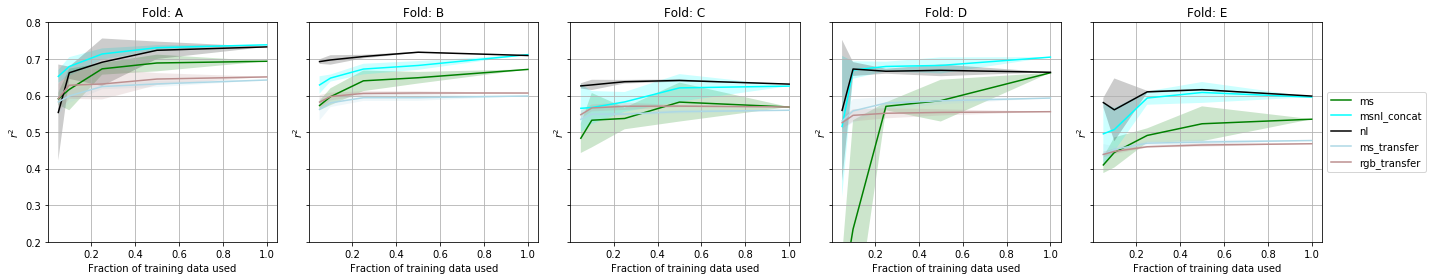

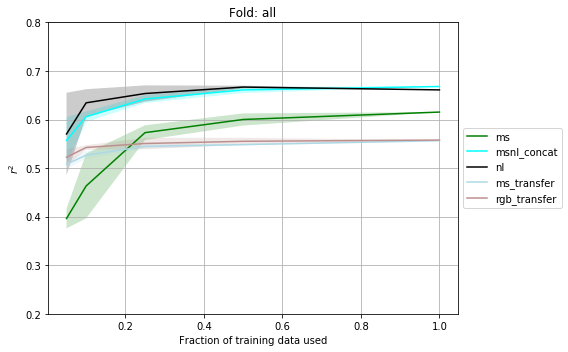

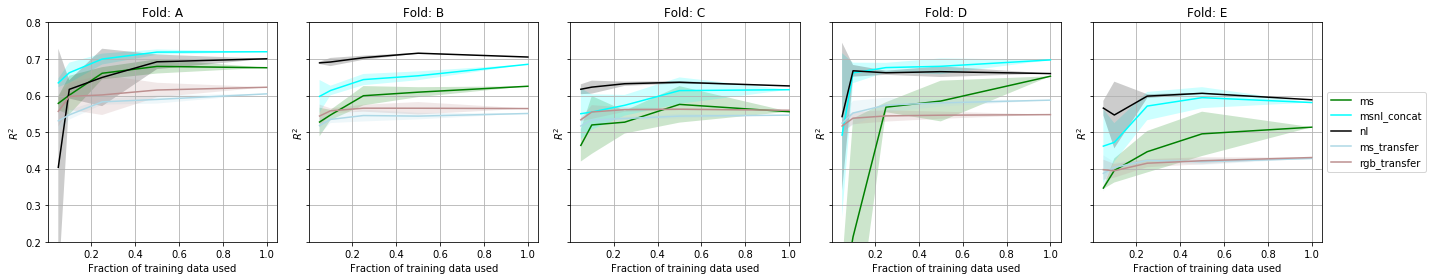

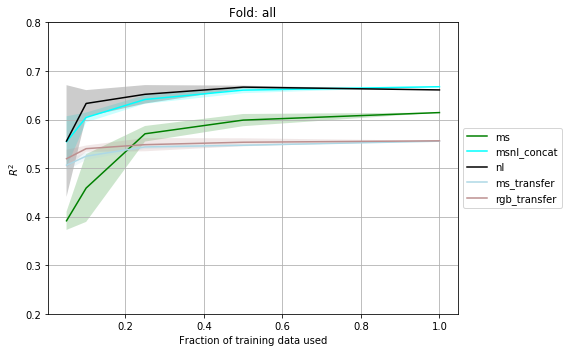

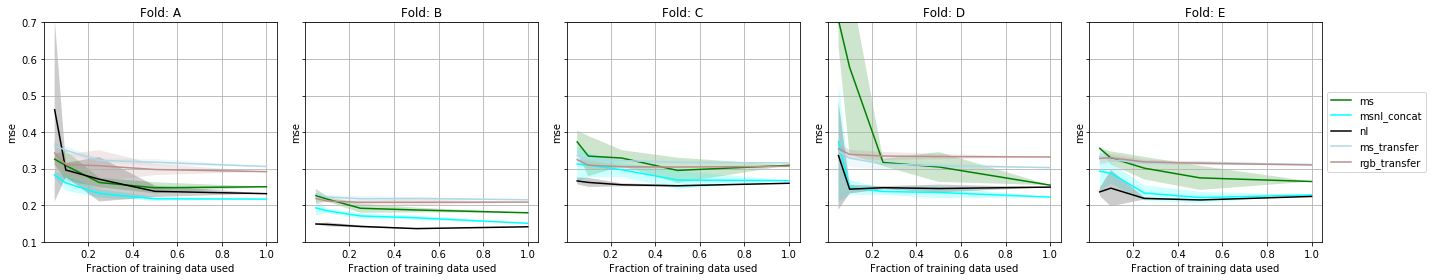

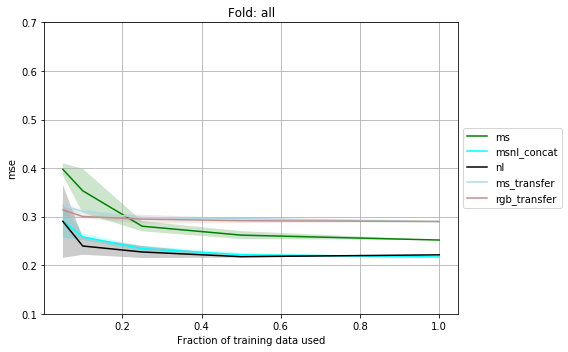

In [20]:
for (metrics, ylabel, ylims) in [
    (r2s, '$r^2$', (0.2, 0.8)),
    (R2s, '$R^2$', (0.2, 0.8)),
    (mses, 'mse', (0.1, 0.7))
]:
    fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[20, 4])
    for i, f in enumerate(FOLDS):
        title = 'Fold: ' + f
        plot_metric_v_keep(ax=axs[i], metrics=metrics[f], ylabel=ylabel,
                           title=title, ylims=ylims, legend=(i==4))
    fig.tight_layout()

    fig, ax = plt.subplots(1, 1, figsize=[8, 5])
    plot_metric_v_keep(ax=ax, metrics=metrics['all'], ylabel=ylabel,
                       title='Fold: all', ylims=ylims)
    fig.tight_layout()
    plt.show()